In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature
from skimage.feature import graycomatrix, graycoprops
import rasterio

In [51]:
from skimage import img_as_ubyte

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.feature import graycomatrix, graycoprops

# Load NIR, Red, and Green band images (replace with your file paths)
nir_image_path = "D:/Jintu/Jintu_ShareFolder/TestDL_2/Landsat Images/Bands/Landsat_Landsat_2022_01_NIR.tif.tif"
red_image_path = "D:/Jintu/Jintu_ShareFolder/TestDL_2/Landsat Images/Bands/Landsat_Landsat_2022_01_RED.tif.tif"
green_image_path = "D:/Jintu/Jintu_ShareFolder/TestDL_2/Landsat Images/Bands/Landsat_Landsat_2022_01_SWIR.tif.tif"

# Open the NIR, Red, and Green band images using rasterio
with rasterio.open(nir_image_path) as nir_src, \
     rasterio.open(red_image_path) as red_src, \
     rasterio.open(green_image_path) as green_src:

    # Read the NIR, Red, and Green band images as numpy arrays
    nir_image = nir_src.read(1)
    red_image = red_src.read(1)
    green_image = green_src.read(1)


In [93]:
print(nir_image.shape)

(2280, 4326)


In [94]:

# Convert the NIR, Red, and Green band images to grayscale
# nir_gray = color.rgb2gray(nir_image)
# red_gray = color.rgb2gray(red_image)
# green_gray = color.rgb2gray(green_image)

# Combine the three grayscale bands into a single grayscale image
combined_gray = nir_image

In [57]:
print(combined_gray.shape)

(2280, 4326)


In [95]:
combined_gray_uint = img_as_ubyte(combined_gray)

In [96]:
print(combined_gray_uint)

[[38 38 30 ... 45 64 83]
 [39 38 29 ... 54 67 62]
 [38 32 25 ... 47 42 23]
 ...
 [47 49 52 ... 52 52 49]
 [47 54 49 ... 55 51 49]
 [61 59 56 ... 55 47 49]]


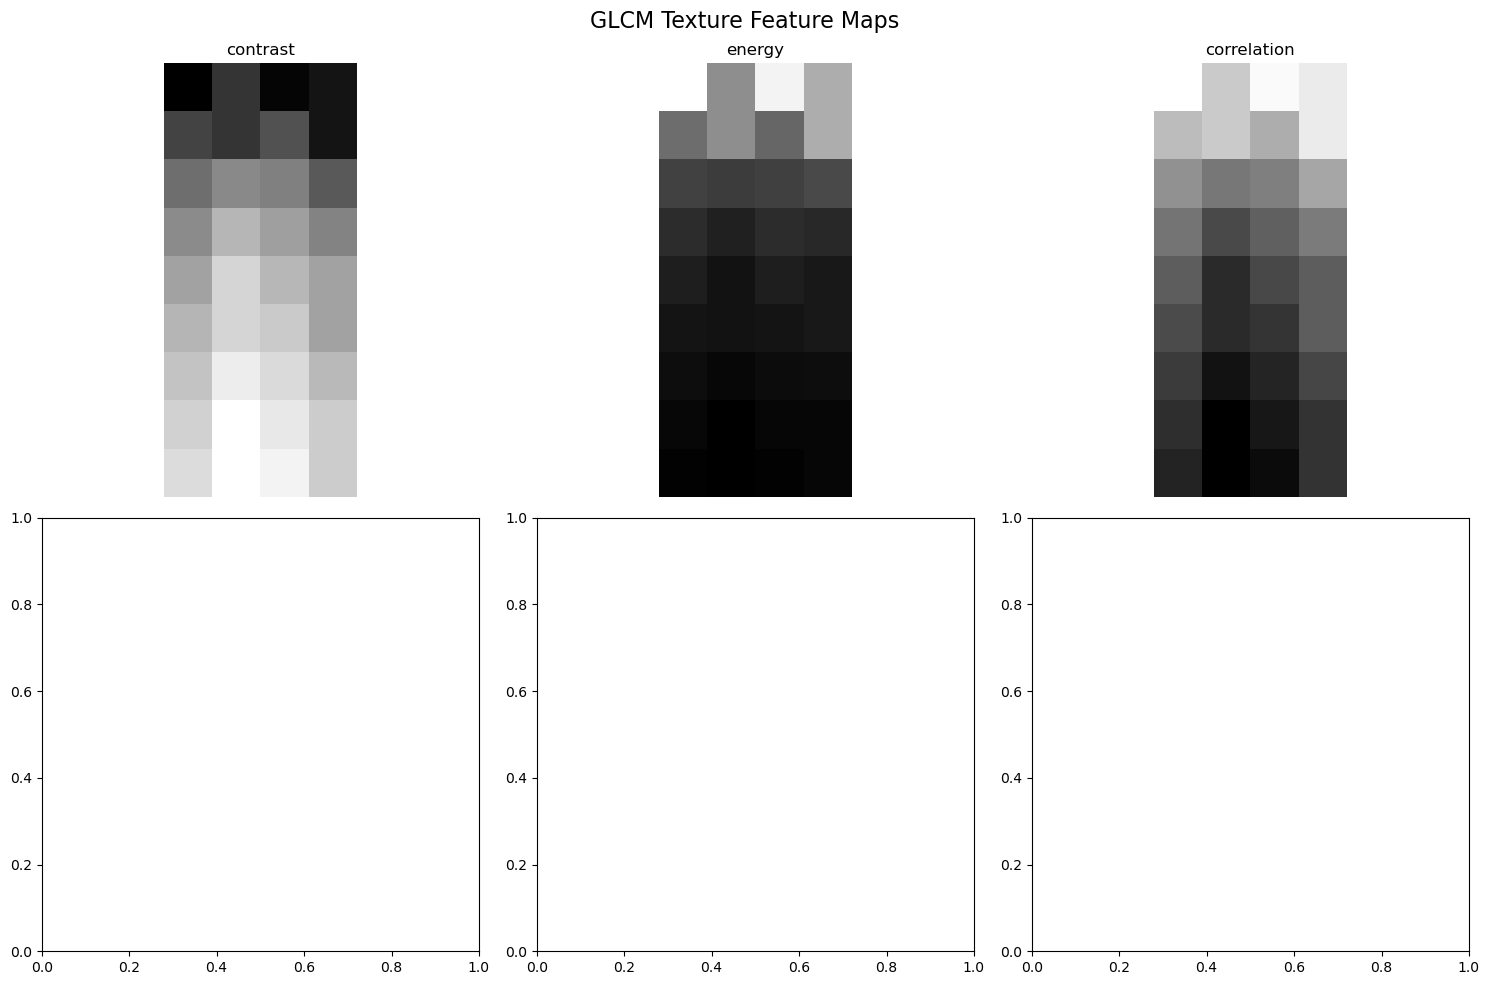

In [97]:
# Define GLCM properties (distance and angles)
distances = [1,2,3,4,5,6,7,8,9]  # You can specify multiple distances
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # You can specify multiple angles

# Calculate GLCM for the combined grayscale image
glcm = graycomatrix(combined_gray_uint, distances, angles)

# Calculate GLCM properties (ASM, variance, homogeneity, contrast, energy, correlation)
# Calculate GLCM properties (contrast, energy, correlation)
properties = ['contrast', 'energy', 'correlation']

results = {}

for prop in properties:
    results[prop] = graycoprops(glcm, prop)

# Display and plot the GLCM texture feature maps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("GLCM Texture Feature Maps", fontsize=16)

for i, (prop, value) in enumerate(results.items()):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.imshow(value, cmap='gray')
    ax.set_title(prop)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [71]:
# Define the output directory where you want to save the TIFF files
output_directory = "D:/Jintu/Jintu_ShareFolder/TestDL_2/Signature/Shapefile/Merge Data/Test_1/Mosaic_Raster/"

# Loop through the results and save each feature map as a TIFF file
for prop, value in results.items():
    # Define the output file path
    output_file_path = f"{output_directory}/{prop}.tif"
    
    # Convert the feature map to a uint8 image (scaled between 0 and 255)
    scaled_value = (value - value.min()) / (value.max() - value.min()) * 255
    scaled_value = scaled_value.astype(np.uint8)
    
    # Save the feature map as a TIFF file
    io.imsave(output_file_path, scaled_value)
    
    print(f"Saved {prop} feature map to {output_file_path}")

Saved contrast feature map to D:/Jintu/Jintu_ShareFolder/TestDL_2/Signature/Shapefile/Merge Data/Test_1/Mosaic_Raster//contrast.tif
Saved energy feature map to D:/Jintu/Jintu_ShareFolder/TestDL_2/Signature/Shapefile/Merge Data/Test_1/Mosaic_Raster//energy.tif
Saved correlation feature map to D:/Jintu/Jintu_ShareFolder/TestDL_2/Signature/Shapefile/Merge Data/Test_1/Mosaic_Raster//correlation.tif


In [98]:
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops
from skimage import io
import cv2
import numpy as np

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.feature import graycomatrix, graycoprops

# Load the image using rasterio
with rasterio.open(nir_image_path) as src:
    image = src.read(1)  # Assuming a single-band image
    
    image = img_as_ubyte(image)

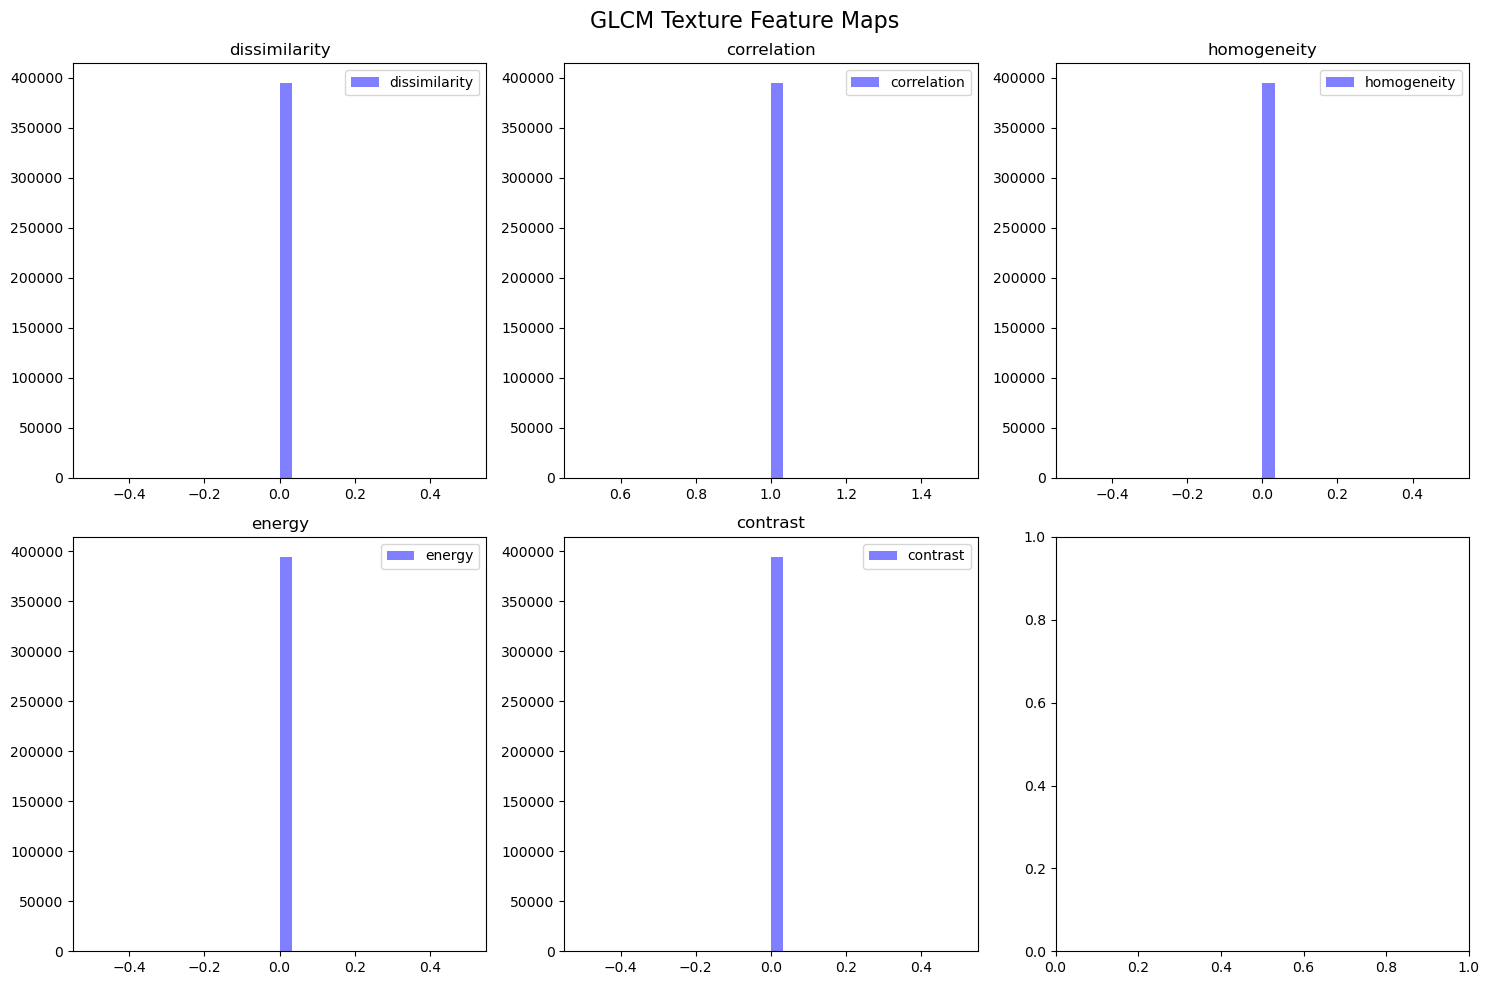

In [100]:
PATCH_SIZE = 5

# Compute some GLCM properties for the entire image
GLCM = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
energy = graycoprops(GLCM, 'energy')[0, 0]

# Extract patches from the entire image
image_height, image_width = image.shape
patch_locations = []

for y in range(0, image_height, PATCH_SIZE):
    for x in range(0, image_width, PATCH_SIZE):
        if y + PATCH_SIZE <= image_height and x + PATCH_SIZE <= image_width:
            patch = image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
            patch_locations.append((y, x, patch))

# Compute GLCM properties for all patches
diss_sim = []
corr = []
homogen = []
energy_patch = []
contrast = []

for _, _, patch in patch_locations:
    glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    diss_sim.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    corr.append(graycoprops(glcm, 'correlation')[0, 0])
    homogen.append(graycoprops(glcm, 'homogeneity')[0, 0])
    energy_patch.append(graycoprops(glcm, 'energy')[0, 0])
    contrast.append(graycoprops(glcm, 'contrast')[0, 0])

# Create subplots for visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("GLCM Texture Feature Maps", fontsize=16)

# Display and plot the GLCM texture feature maps
for i, (prop, value) in enumerate(zip(['dissimilarity', 'correlation', 'homogeneity', 'energy', 'contrast'],
                                      [diss_sim, corr, homogen, energy_patch, contrast])):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.hist(value, bins=30, color='b', alpha=0.5, label=prop)
    ax.set_title(prop)
    ax.legend()

plt.tight_layout()
plt.show()


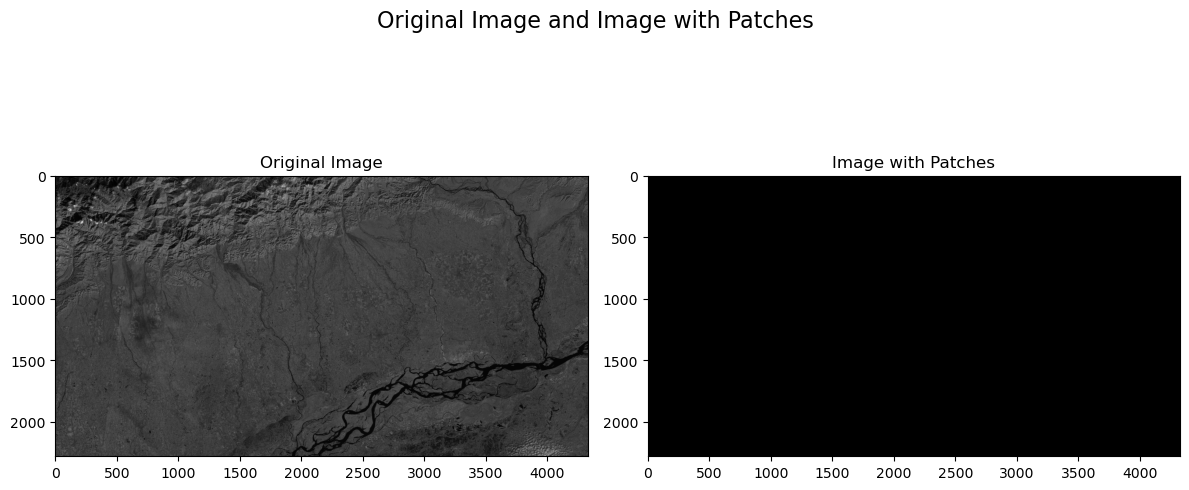

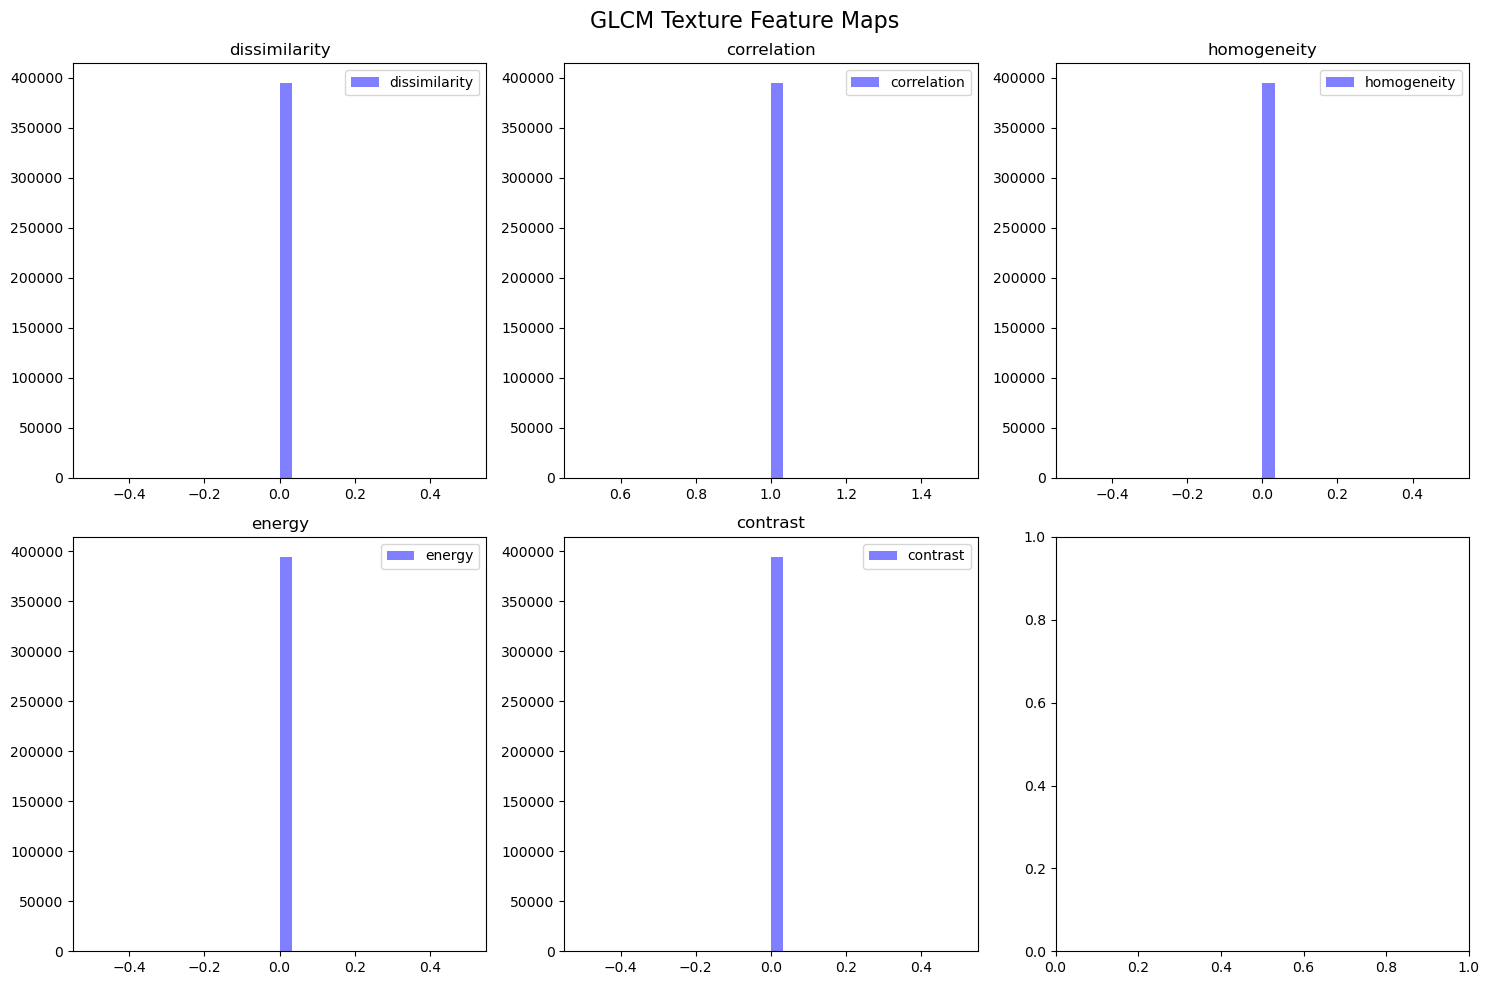

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.feature import graycomatrix, graycoprops
from skimage import img_as_ubyte

# Load the image using rasterio
with rasterio.open(nir_image_path) as src:
    image = src.read(1)  # Assuming a single-band image
    
    image = img_as_ubyte(image)

PATCH_SIZE = 5

# Compute some GLCM properties for the entire image
GLCM = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
energy = graycoprops(GLCM, 'energy')[0, 0]

# Extract patches from the entire image
image_height, image_width = image.shape
patch_locations = []

for y in range(0, image_height, PATCH_SIZE):
    for x in range(0, image_width, PATCH_SIZE):
        if y + PATCH_SIZE <= image_height and x + PATCH_SIZE <= image_width:
            patch = image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
            patch_locations.append((y, x, patch))

# Create a blank image with the same shape as the original image
blank_image = np.zeros_like(image)

# Place the patches onto the blank image and calculate GLCM properties
diss_sim = []
corr = []
homogen = []
energy_patch = []
contrast = []

for _, _, patch in patch_locations:
    glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    diss_sim.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    corr.append(graycoprops(glcm, 'correlation')[0, 0])
    homogen.append(graycoprops(glcm, 'homogeneity')[0, 0])
    energy_patch.append(graycoprops(glcm, 'energy')[0, 0])
    contrast.append(graycoprops(glcm, 'contrast')[0, 0])

# Create subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Original Image and Image with Patches", fontsize=16)

# Display the original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")

# Display the image with patches
axes[1].imshow(blank_image, cmap='gray')
axes[1].set_title("Image with Patches")

plt.tight_layout()
plt.show()

# Create subplots for GLCM texture feature maps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("GLCM Texture Feature Maps", fontsize=16)

# Display and plot the GLCM texture feature maps
for i, (prop, value) in enumerate(zip(['dissimilarity', 'correlation', 'homogeneity', 'energy', 'contrast'],
                                      [diss_sim, corr, homogen, energy_patch, contrast])):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.hist(value, bins=30, color='b', alpha=0.5, label=prop)
    ax.set_title(prop)
    ax.legend()

plt.tight_layout()
plt.show()


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.feature import graycomatrix, graycoprops
from skimage import img_as_ubyte

# Load the image using rasterio
with rasterio.open(nir_image_path) as src:
    image = src.read(1)  # Assuming a single-band image
    
    image = img_as_ubyte(image)

PATCH_SIZE = 5

# Compute some GLCM properties for the entire image
GLCM = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
energy = graycoprops(GLCM, 'energy')[0, 0]

# Extract patches from the entire image
image_height, image_width = image.shape
patch_locations = []

for y in range(0, image_height, PATCH_SIZE):
    for x in range(0, image_width, PATCH_SIZE):
        if y + PATCH_SIZE <= image_height and x + PATCH_SIZE <= image_width:
            patch = image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
            patch_locations.append(patch)

# Create a blank image with the same shape as the original image
blank_image = np.zeros_like(image)

# Place the patches onto the blank image and calculate GLCM properties
# diss_sim = np.zeros_like(image, dtype=np.float64)
# corr = np.zeros_like(image, dtype=np.float64)
# homogen = np.zeros_like(image, dtype=np.float64)
# energy_patch = np.zeros_like(image, dtype=np.float64)
# contrast = np.zeros_like(image, dtype=np.float64)

for patch in patch_locations:
    # Calculate GLCM properties for each patch
    glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    diss_sim += graycoprops(glcm, 'dissimilarity')[0, 0]
    corr += graycoprops(glcm, 'correlation')[0, 0]
    homogen += graycoprops(glcm, 'homogeneity')[0, 0]
    energy_patch += graycoprops(glcm, 'energy')[0, 0]
    contrast += graycoprops(glcm, 'contrast')[0, 0]

# Create subplots for visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Original Image and Image with Patches", fontsize=16)

# Display the original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")

# Display the image with patches
axes[1].imshow(blank_image, cmap='gray')
axes[1].set_title("Image with Patches")

plt.tight_layout()
plt.show()

# Create subplots for GLCM texture feature maps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("GLCM Texture Feature Maps", fontsize=16)

# Display and plot the GLCM texture feature maps
properties = ['dissimilarity', 'correlation', 'homogeneity', 'energy', 'contrast']
property_images = [diss_sim, corr, homogen, energy_patch, contrast]

for i, (prop, prop_image) in enumerate(zip(properties, property_images)):
    ax = axes[i // 3, i % 3]
    ax.imshow(prop_image, cmap='gray')
    ax.set_title(prop)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [89]:
print('k')

k


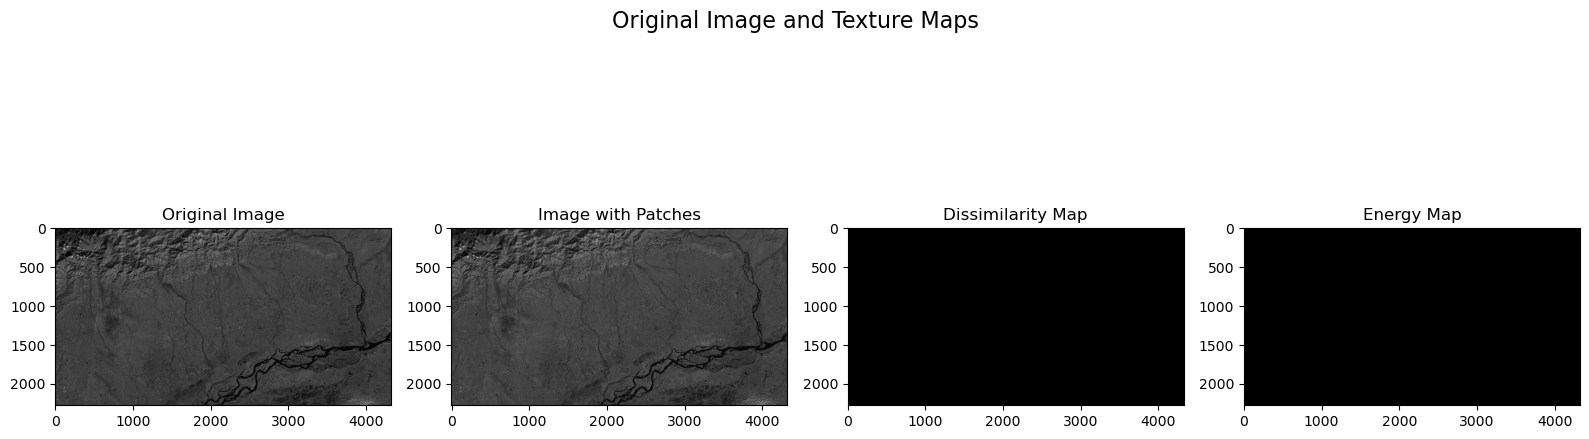

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.feature import graycomatrix, graycoprops
from skimage import img_as_ubyte

# Load the image using rasterio
with rasterio.open(nir_image_path) as src:
    image = src.read(1)  # Assuming a single-band image
    
    image = img_as_ubyte(image)

PATCH_SIZE = 5

# Compute some GLCM properties for the entire image
GLCM = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
energy = graycoprops(GLCM, 'energy')[0, 0]

# Extract patches from the entire image
image_height, image_width = image.shape
patch_locations = []

for y in range(0, image_height, PATCH_SIZE):
    for x in range(0, image_width, PATCH_SIZE):
        if y + PATCH_SIZE <= image_height and x + PATCH_SIZE <= image_width:
            patch = image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
            patch_locations.append((y, x, patch))

# Create a blank image with the same shape as the original image
blank_image = np.zeros_like(image)

# Place the patches onto the blank image and calculate GLCM properties
diss_sim = np.zeros_like(image, dtype=np.float64)
corr = np.zeros_like(image, dtype=np.float64)
energy_patch = np.zeros_like(image, dtype=np.float64)

for y, x, patch in patch_locations:
    blank_image[y:y + PATCH_SIZE, x:x + PATCH_SIZE] = patch
    
    # Calculate GLCM properties for each patch
    glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    diss_sim[y:y + PATCH_SIZE, x:x + PATCH_SIZE] = graycoprops(glcm, 'dissimilarity')[0, 0]
    corr[y:y + PATCH_SIZE, x:x + PATCH_SIZE] = graycoprops(glcm, 'correlation')[0, 0]
    energy_patch[y:y + PATCH_SIZE, x:x + PATCH_SIZE] = graycoprops(glcm, 'energy')[0, 0]

# Create subplots for visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Original Image and Texture Maps", fontsize=16)

# Display the original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")

# Display the image with patches
axes[1].imshow(blank_image, cmap='gray')
axes[1].set_title("Image with Patches")

# Display the texture maps
axes[2].imshow(diss_sim, cmap='gray')
axes[2].set_title("Dissimilarity Map")

axes[3].imshow(energy_patch, cmap='gray')
axes[3].set_title("Energy Map")

plt.tight_layout()
plt.show()


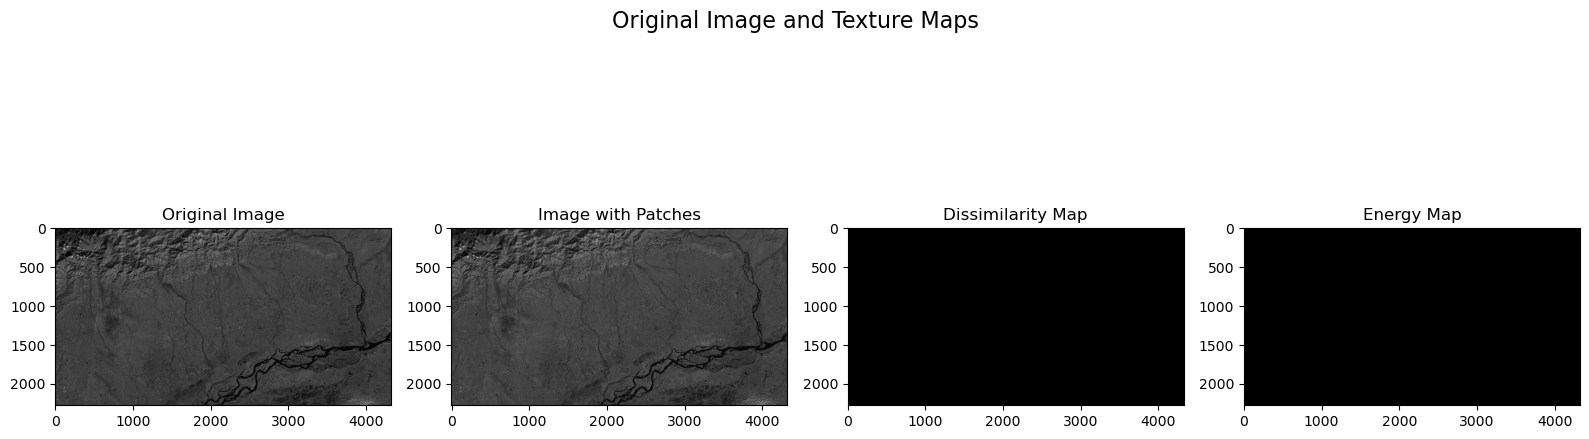

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.feature import graycomatrix, graycoprops
from skimage import img_as_ubyte

# Load the image using rasterio
with rasterio.open(nir_image_path) as src:
    image = src.read(1)  # Assuming a single-band image
    
    image = img_as_ubyte(image)

PATCH_SIZE = 10

# Compute some GLCM properties for the entire image
GLCM = graycomatrix(image, [10], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
energy = graycoprops(GLCM, 'energy')[0, 0]

# Extract patches from the entire image
image_height, image_width = image.shape
patch_locations = []

for y in range(0, image_height, PATCH_SIZE):
    for x in range(0, image_width, PATCH_SIZE):
        if y + PATCH_SIZE <= image_height and x + PATCH_SIZE <= image_width:
            patch = image[y:y + PATCH_SIZE, x:x + PATCH_SIZE]
            patch_locations.append((y, x, patch))

# Create a blank image with the same shape as the original image
blank_image = np.zeros_like(image)

# Place the patches onto the blank image and calculate GLCM properties
diss_sim = np.zeros_like(image, dtype=np.float64)
corr = np.zeros_like(image, dtype=np.float64)
energy_patch = np.zeros_like(image, dtype=np.float64)

for y, x, patch in patch_locations:
    blank_image[y:y + PATCH_SIZE, x:x + PATCH_SIZE] = patch
    
    # Calculate GLCM properties for each patch
    glcm = graycomatrix(patch, [10], [0], levels=256, symmetric=True, normed=True)
    diss_sim[y:y + PATCH_SIZE, x:x + PATCH_SIZE] = graycoprops(glcm, 'dissimilarity')[0, 0]
    corr[y:y + PATCH_SIZE, x:x + PATCH_SIZE] = graycoprops(glcm, 'correlation')[0, 0]
    energy_patch[y:y + PATCH_SIZE, x:x + PATCH_SIZE] = graycoprops(glcm, 'energy')[0, 0]

# Create subplots for visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Original Image and Texture Maps", fontsize=16)

# Display the original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")

# Display the image with patches
axes[1].imshow(blank_image, cmap='gray')
axes[1].set_title("Image with Patches")

# Display the texture maps
axes[2].imshow(diss_sim, cmap='gray')
axes[2].set_title("Dissimilarity Map")

axes[3].imshow(energy_patch, cmap='gray')
axes[3].set_title("Energy Map")

plt.tight_layout()
plt.show()
